<a href="https://colab.research.google.com/github/rujool11/ML-learning/blob/main/06_Transfer_Learning_Scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Scaling up, food 101**

baseline to beat: 50.76% across 101 classes (original food101 paper)

### **Get and set up data, helper functions**

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-10-16 09:54:41--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-16 09:54:41 (73.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
from helper_functions import plot_loss_curves, compare_historys, walk_through_dir, unzip_data

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data('101_food_classes_10_percent.zip')
train_dir_10_percent = '101_food_classes_10_percent/train/'
test_dir = '101_food_classes_10_percent/test/'

--2023-10-16 09:54:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.207, 142.250.97.207, 142.251.107.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   134MB/s    in 13s     

2023-10-16 09:55:00 (120 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/carrot_cake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/gyoza'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beignets'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pho'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/red_velvet_cake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/greek_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/scallops'.
There are 0 directories and 75 images in '101_food_classes_1

In [5]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                                image_size=IMG_SIZE,
                                                                                label_mode='categorical') # shuffle true by default

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # set shuffle to false since we dont want order to change (see later)


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


### **Create checkpoint callback, data augmentation layer and base model**

In [ ]:
# checkpoint callback
checkpoint_path = '101_classes_10_percent_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # we can also save whole model but that takes longer
                                                         monitor='val_accuracy',
                                                         save_best_only=True) # will save weights with best val_accuracy


In [ ]:
# create data augmentation layer
from tensorflow.keras import layers
from tensorflow.keras import Sequential

data_augmentation = Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    # layers.Rescaling(1/255.) not needed as efficintnet already rescales data
], name='data_augmentation')


### **Create and fit model**

In [ ]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False) # not including top since we use own output layer
base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False) # weights that need to stay frozen are frozen
x = layers.GlobalAveragePooling2D(name='global_avg_pool_layer')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation='softmax', name='output_layer')(x)

model = tf.keras.Model(inputs, outputs)

24274472/24274472 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_avg_pool_layer (Glo  (None, 1280)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

hist_10_percent = model.fit(train_data_all_10_percent,
                            epochs=5,
                            steps_per_epoch=len(train_data_all_10_percent),
                            validation_data=test_data,
                            validation_steps=len(test_data),
                            callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 196s 755ms/step - loss: 3.5141 - accuracy: 0.2366 - val_loss: 2.4512 - val_accuracy: 0.4465
Epoch 2/5
237/237 [==============================] - 143s 603ms/step - loss: 2.4157 - accuracy: 0.4502 - val_loss: 1.9715 - val_accuracy: 0.5187
Epoch 3/5
237/237 [==============================] - 126s 532ms/step - loss: 2.0432 - accuracy: 0.5234 - val_loss: 1.7744 - val_accuracy: 0.5519
Epoch 4/5
237/237 [==============================] - 111s 468ms/step - loss: 1.8446 - accuracy: 0.5603 - val_loss: 1.6764 - val_accuracy: 0.5699
Epoch 5/5
237/237 [==============================] - 108s 455ms/step - loss: 1.6943 - accuracy: 0.5856 - val_loss: 1.6136 - val_accuracy: 0.5796


In [ ]:
res_1 = model.evaluate(test_data)

790/790 [==============================] - 55s 69ms/step - loss: 1.6136 - accuracy: 0.5796


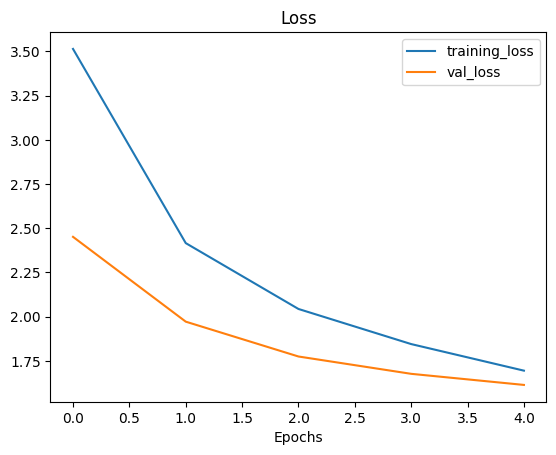

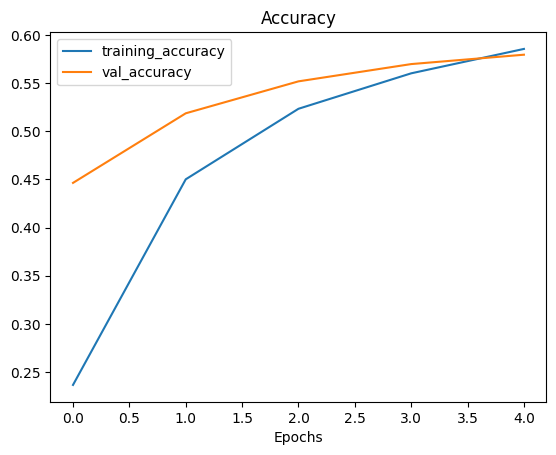

In [ ]:
plot_loss_curves(hist_10_percent)

### **Fine tuning**

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-5]: # unfreeze last 5 layers (since working pretty good we unfreeze last 5)
  layer.trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lower learning rate by 10x
              metrics=['accuracy'])


In [ ]:
for layer in model.layers:
  print(layer.name, ': ', layer.trainable)

input_layer :  True
data_augmentation :  True
efficientnetv2-b0 :  True
global_avg_pool_layer :  True
output_layer :  True


In [ ]:
for i, layer in enumerate(model.layers[2].layers):
  print(i, layer.name, ':', layer.trainable)

# if you have a huge dataset, increase the number of layers you are fine tuning, typically start lower

0 input_1 : False
1 rescaling : False
2 normalization : False
3 stem_conv : False
4 stem_bn : False
5 stem_activation : False
6 block1a_project_conv : False
7 block1a_project_bn : False
8 block1a_project_activation : False
9 block2a_expand_conv : False
10 block2a_expand_bn : False
11 block2a_expand_activation : False
12 block2a_project_conv : False
13 block2a_project_bn : False
14 block2b_expand_conv : False
15 block2b_expand_bn : False
16 block2b_expand_activation : False
17 block2b_project_conv : False
18 block2b_project_bn : False
19 block2b_drop : False
20 block2b_add : False
21 block3a_expand_conv : False
22 block3a_expand_bn : False
23 block3a_expand_activation : False
24 block3a_project_conv : False
25 block3a_project_bn : False
26 block3b_expand_conv : False
27 block3b_expand_bn : False
28 block3b_expand_activation : False
29 block3b_project_conv : False
30 block3b_project_bn : False
31 block3b_drop : False
32 block3b_add : False
33 block4a_expand_conv : False
34 block4a_expand

In [ ]:
fine_tune_epochs = 10 # model has already completed 5, this is total

hist_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                      epochs=fine_tune_epochs,
                                      validation_data=test_data,
                                      validation_steps=int(0.15*len(test_data)),
                                      initial_epoch=hist_10_percent.epoch[-1]+1)

Epoch 6/10
237/237 [==============================] - 72s 262ms/step - loss: 1.4778 - accuracy: 0.6285 - val_loss: 1.7789 - val_accuracy: 0.5331
Epoch 7/10
237/237 [==============================] - 53s 223ms/step - loss: 1.3779 - accuracy: 0.6408 - val_loss: 1.7836 - val_accuracy: 0.5323
Epoch 8/10
237/237 [==============================] - 70s 296ms/step - loss: 1.3185 - accuracy: 0.6564 - val_loss: 1.7795 - val_accuracy: 0.5376
Epoch 9/10
237/237 [==============================] - 55s 232ms/step - loss: 1.2716 - accuracy: 0.6683 - val_loss: 1.7712 - val_accuracy: 0.5421
Epoch 10/10
237/237 [==============================] - 54s 225ms/step - loss: 1.2428 - accuracy: 0.6709 - val_loss: 1.7761 - val_accuracy: 0.5397


In [ ]:
res_2 = model.evaluate(test_data)

790/790 [==============================] - 82s 90ms/step - loss: 1.4742 - accuracy: 0.6060


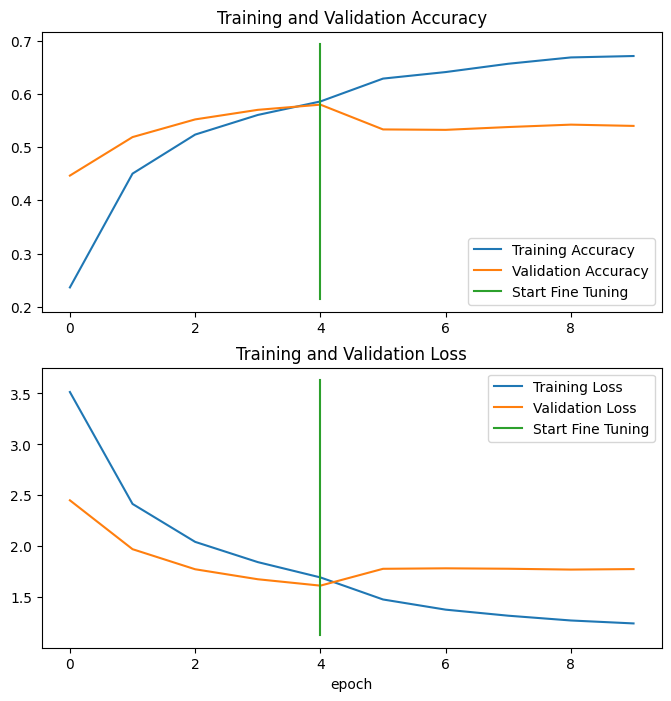

In [ ]:
compare_historys(hist_10_percent, hist_10_percent_fine_tune)

In [ ]:
model.save('drive/MyDrive/Models/101_food_classes_10_percent')

In [ ]:
loaded_model = tf.keras.models.load_model('drive/MyDrive/Models/101_food_classes_10_percent')

In [ ]:
loaded_model_res = loaded_model.evaluate(test_data)
loaded_model_res

790/790 [==============================] - 57s 69ms/step - loss: 1.4742 - accuracy: 0.6060


[1.4741636514663696, 0.6059802174568176]

In [ ]:
res_2

[1.4741636514663696, 0.6059802174568176]

### **Making predictions**

In [7]:
pred_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 1922s 2s/step


In [8]:
len(test_data)

790

In [9]:
pred_probs.shape

(25250, 101)

In [10]:
pred_probs[0], len(pred_probs[0]), sum(pred_probs[0])

(array([7.77346839e-04, 7.74689215e-06, 4.20315824e-02, 2.50087055e-07,
        1.92276329e-05, 5.35235959e-05, 9.28611553e-06, 5.26099029e-06,
        1.59195988e-04, 1.17098192e-04, 6.38312440e-06, 1.70103558e-05,
        5.04408381e-05, 1.41495248e-05, 4.96066222e-03, 6.34231512e-03,
        5.24117495e-04, 4.34839050e-04, 7.69994047e-04, 3.10101866e-04,
        7.27954844e-04, 2.20525067e-06, 1.53588426e-05, 8.89854073e-06,
        3.36683624e-05, 8.44724709e-04, 7.37309514e-04, 2.23248207e-06,
        1.30487988e-02, 2.16762182e-05, 5.49543586e-07, 4.06325635e-05,
        3.26184346e-03, 6.20319333e-05, 9.73157119e-04, 2.24399682e-05,
        1.30824663e-03, 1.26824097e-03, 1.38775166e-02, 1.79554423e-04,
        9.58447636e-04, 2.14807937e-04, 2.80175300e-05, 1.06000676e-04,
        3.67760913e-05, 2.11933839e-05, 1.50500666e-04, 1.28631000e-04,
        2.04862208e-05, 1.46532636e-02, 5.38617780e-04, 9.58663368e-05,
        1.87667962e-02, 1.15610696e-02, 6.81257518e-07, 4.005239

In [11]:
# one probability per class, with a 101 different probabilities
pred_probs[0].argmax() # argmax returns index with largest value

85

In [12]:
pred_classes = pred_probs.argmax(axis=1)
len(pred_classes), pred_classes[:10]

(25250, array([85,  0,  0,  0,  8, 78, 29, 46,  0, 41]))

In [13]:
test_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

### **we have prediction array, to compare then to the original test dataset**

In [14]:
# to get test label, unravel batch dataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10] # all 0 since not shuffled

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [15]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.605980198019802

### **make confusion matrix**

In [17]:
class_names = test_data.class_names
class_names[:10] # not shuffled to match up with predicted classes

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

In [ ]:
# from confusion matrix, we can see what labels the model is getting mixes up/confused

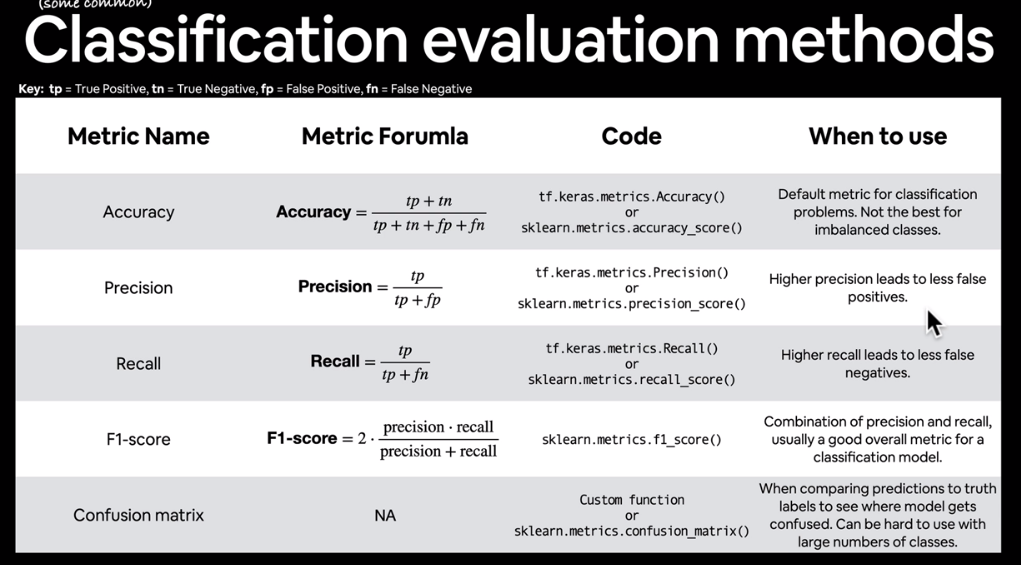

In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.41      0.19      0.26       250
           1       0.63      0.66      0.64       250
           2       0.65      0.52      0.58       250
           3       0.79      0.51      0.62       250
           4       0.54      0.39      0.45       250
           5       0.58      0.40      0.48       250
           6       0.79      0.77      0.78       250
           7       0.84      0.67      0.75       250
           8       0.40      0.45      0.42       250
           9       0.41      0.70      0.52       250
          10       0.58      0.42      0.49       250
          11       0.65      0.58      0.61       250
          12       0.80      0.56      0.66       250
          13       0.54      0.64      0.58       250
          14       0.38      0.67      0.48       250
          15       0.37      0.31      0.34       250
          16       0.64      0.54      0.58       250
          17       0.39    

In [19]:
classification_report_dict = classification_report(y_true=y_labels,
                                                   y_pred=pred_classes,
                                                   output_dict=True)
classification_report_dict['0'] # showing report for 0th class

{'precision': 0.4067796610169492,
 'recall': 0.192,
 'f1-score': 0.26086956521739135,
 'support': 250}

### **plot f1 scores**

In [20]:
class_f1_scores = {}
for k, v in classification_report_dict.items():
  if k=='accuracy': # stop once we reach accuracy
    break
  else:
    class_f1_scores[class_names[int(k)]] = v['f1-score']
class_f1_scores

{'apple_pie': 0.26086956521739135,
 'baby_back_ribs': 0.640625,
 'baklava': 0.5777777777777778,
 'beef_carpaccio': 0.6180048661800487,
 'beef_tartare': 0.4547563805104408,
 'beet_salad': 0.47641509433962265,
 'beignets': 0.7773279352226721,
 'bibimbap': 0.7466666666666666,
 'bread_pudding': 0.4218455743879473,
 'breakfast_burrito': 0.5208333333333333,
 'bruschetta': 0.4883720930232558,
 'caesar_salad': 0.6114649681528662,
 'cannoli': 0.6619718309859155,
 'caprese_salad': 0.5824175824175825,
 'carrot_cake': 0.48137535816618904,
 'ceviche': 0.33766233766233766,
 'cheese_plate': 0.5844155844155845,
 'cheesecake': 0.42857142857142855,
 'chicken_curry': 0.478448275862069,
 'chicken_quesadilla': 0.5887096774193549,
 'chicken_wings': 0.7041036717062635,
 'chocolate_cake': 0.5714285714285713,
 'chocolate_mousse': 0.4040404040404041,
 'churros': 0.7300884955752213,
 'clam_chowder': 0.7520661157024793,
 'club_sandwich': 0.615678776290631,
 'crab_cakes': 0.4139020537124802,
 'creme_brulee': 0.705

In [21]:
import pandas as pd
f1_scores = pd.DataFrame({'class_names': list(class_f1_scores.keys()),
                          'f1_scores': list(class_f1_scores.values())}).sort_values('f1_scores', ascending=False)
f1_scores.head()

class_names  f1_scores
33              edamame   0.953846
63             macarons   0.902128
75                  pho   0.870445
91  spaghetti_carbonara   0.858716
69              oysters   0.852459

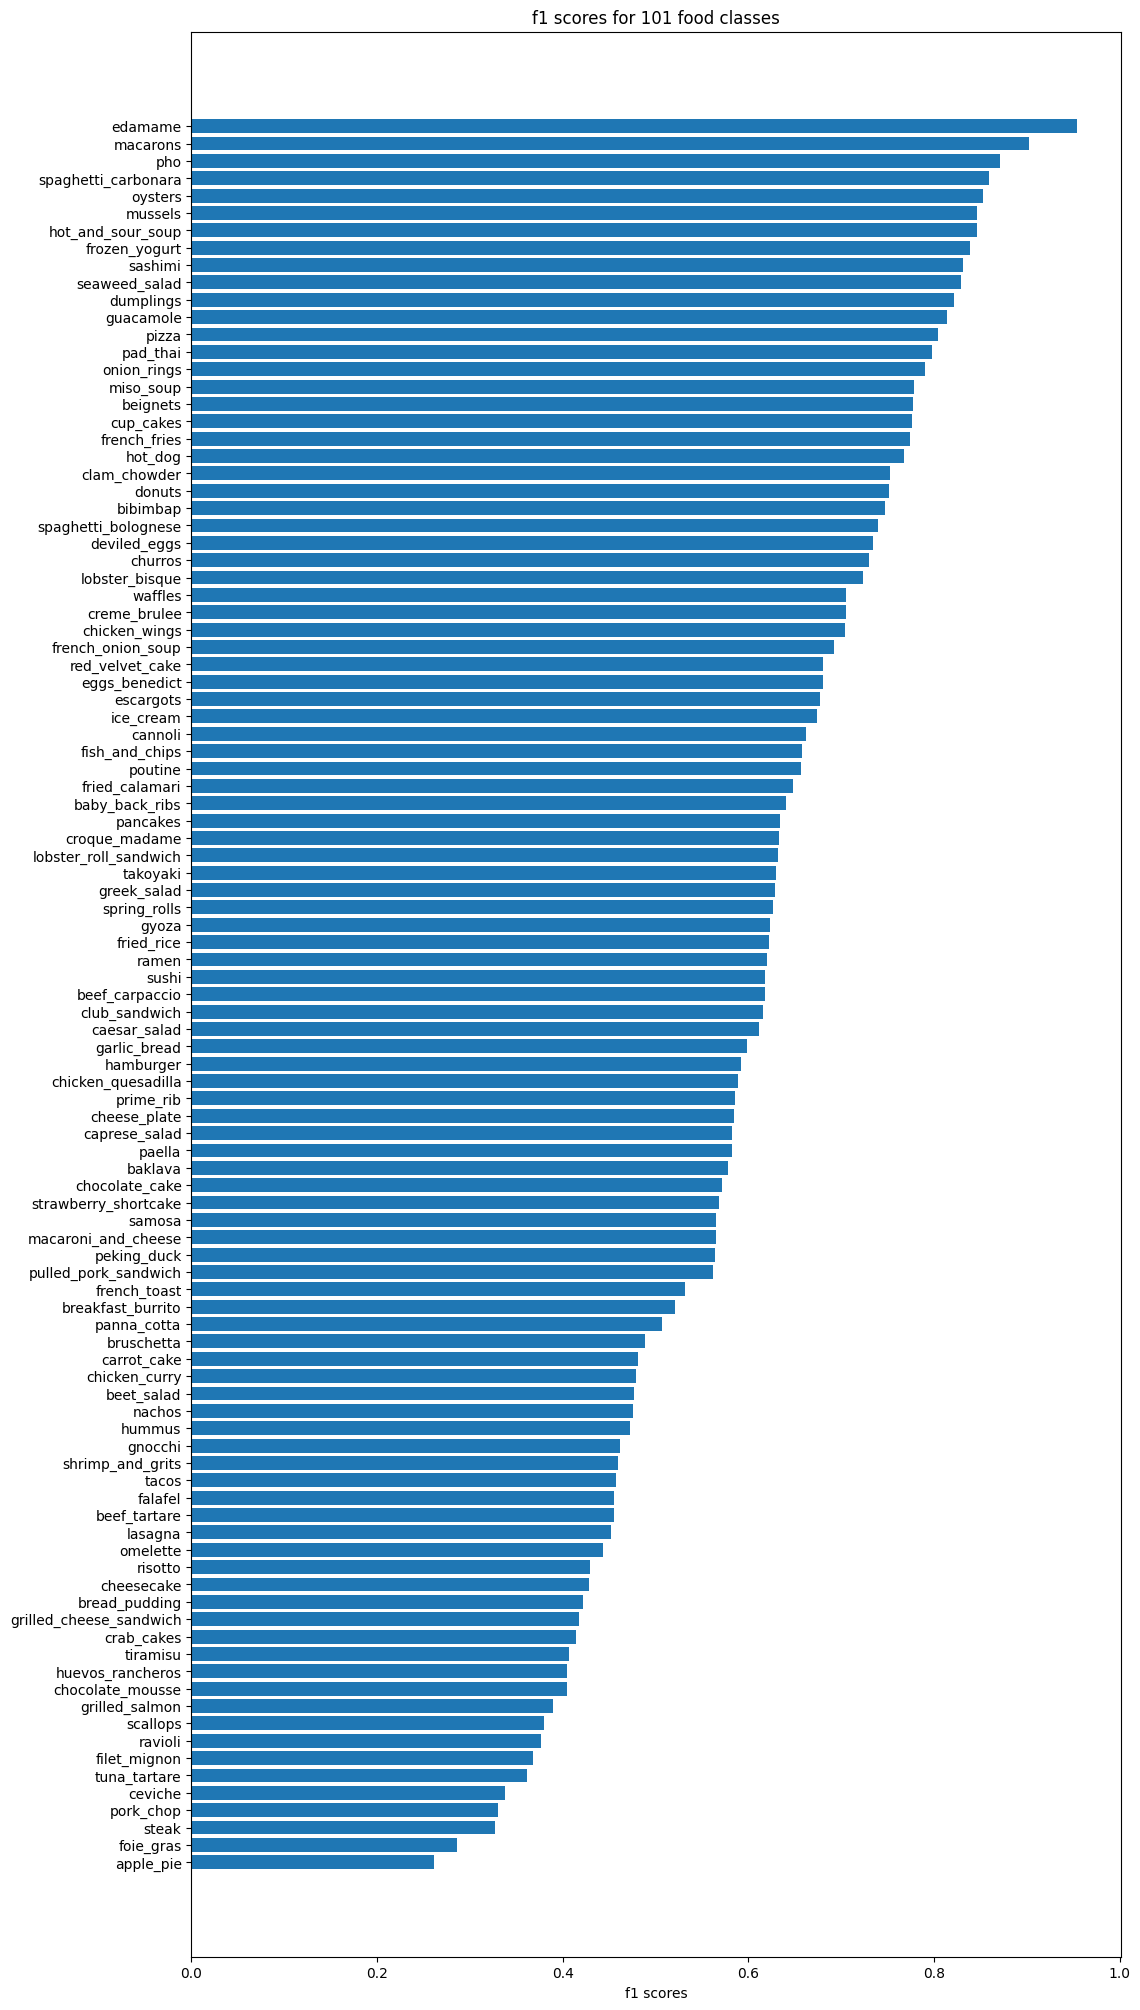

In [22]:
import matplotlib.pyplot as plt
# make horizontal bar graph, look up details later
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1_scores'].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_names'])
ax.set_xlabel('f1 scores')
ax.set_title('f1 scores for 101 food classes')
ax.invert_yaxis();

In [ ]:
# saving model
model.save('/content/drive/MyDrive/Models/latest')

In [6]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/drive/MyDrive/Models/latest')

### **Visualizing predictions for test images**

function to read file path, turn into tensor and then resize to be same size as training images, then scale for pixel values (not needed for efficientnet because inbuilt)


In [32]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  '''
  Args:
  filename: path to target image
  img_shape: dimension of target image size
  scale: whether to resize image or not
  '''
  img = tf.io.read_file(filename)
  img = tf.io.decode_image(img, channels=3) # channels are hardcoded
  img = tf.image.resize(img, [img_shape, img_shape])

  if scale:
    return img/255.
  else:
    return img;

1/1 [==============================] - 0s 91ms/step


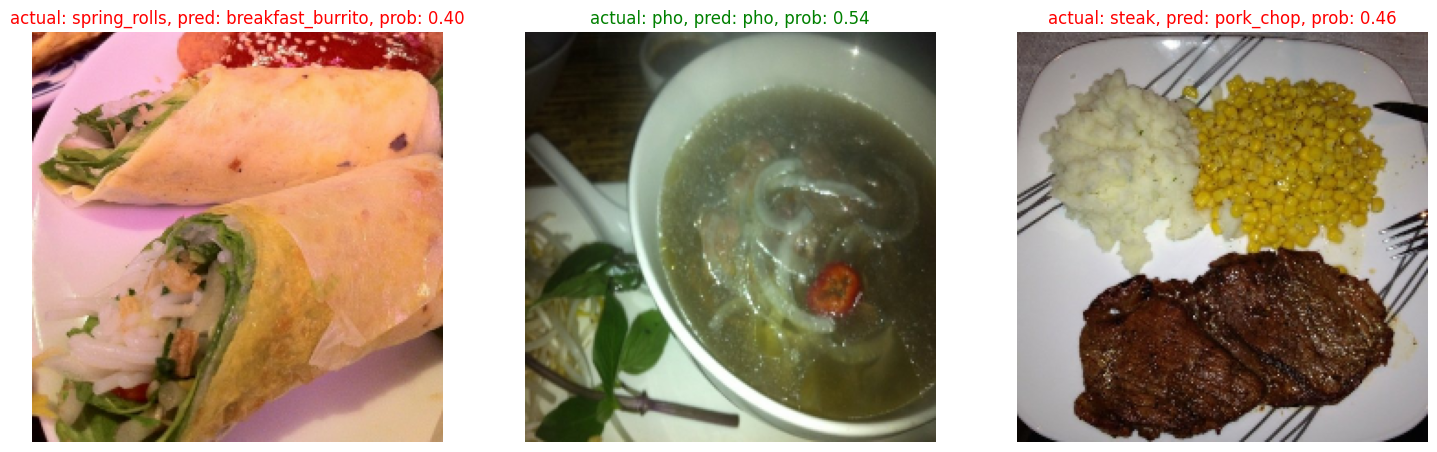

In [24]:
import matplotlib.pyplot as plt
import os
import random

plt.figure(figsize=(18, 14))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

### **Finding most wrong predictions**


1. create DataFrame with image filepaths, truth labels, classes etc

2. use DataFrame to find wrong predictions (where truth label doesnt match prediction)

3. sort DataFrame based on wrong predictions

4. visualize image with most wrong predictions

In [26]:
filepaths = []
import numpy as np
for filepath in test_data.list_files('/content/101_food_classes_10_percent/test/*/*.jpg',
                                     shuffle=False):
  filepaths.append(filepath.numpy())

filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [28]:
pred_df = pd.DataFrame({
    'img_path' : filepaths,
    'y_true' : y_labels,
    'y_pred' : pred_classes,
    'pred_conf' : pred_probs.max(axis=1), # max prediction probabilty value across axis 1
    'y_true_classnames' : [class_names[i] for i in y_labels],
    'y_pred_classnames' : [class_names[i] for i in pred_classes]
})
# pred_conf is prediction confidence

pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/101_food_classes_10_percent/test/ap...       0      85   
1  b'/content/101_food_classes_10_percent/test/ap...       0       0   
2  b'/content/101_food_classes_10_percent/test/ap...       0       0   
3  b'/content/101_food_classes_10_percent/test/ap...       0       0   
4  b'/content/101_food_classes_10_percent/test/ap...       0       8   

   pred_conf y_true_classnames y_pred_classnames  
0   0.761303         apple_pie            samosa  
1   0.773469         apple_pie         apple_pie  
2   0.307076         apple_pie         apple_pie  
3   0.190247         apple_pie         apple_pie  
4   0.582578         apple_pie     bread_pudding

In [29]:
pred_df['correct'] = pred_df['y_true'] == pred_df['y_pred']
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/101_food_classes_10_percent/test/ap...       0      85   
1  b'/content/101_food_classes_10_percent/test/ap...       0       0   
2  b'/content/101_food_classes_10_percent/test/ap...       0       0   
3  b'/content/101_food_classes_10_percent/test/ap...       0       0   
4  b'/content/101_food_classes_10_percent/test/ap...       0       8   

   pred_conf y_true_classnames y_pred_classnames  correct  
0   0.761303         apple_pie            samosa    False  
1   0.773469         apple_pie         apple_pie     True  
2   0.307076         apple_pie         apple_pie     True  
3   0.190247         apple_pie         apple_pie     True  
4   0.582578         apple_pie     bread_pudding    False

In [30]:
top_100_wrong = pred_df[pred_df['correct']==False].sort_values('pred_conf', ascending=False)[:100]
top_100_wrong.head()

img_path  y_true  y_pred  \
14482  b'/content/101_food_classes_10_percent/test/hu...      57      51   
18001  b'/content/101_food_classes_10_percent/test/pa...      72      67   
23797  b'/content/101_food_classes_10_percent/test/su...      95      86   
10880  b'/content/101_food_classes_10_percent/test/fr...      43      68   
17908  b'/content/101_food_classes_10_percent/test/pa...      71      65   

       pred_conf y_true_classnames y_pred_classnames  correct  
14482   0.997167            hummus         guacamole    False  
18001   0.996976          pancakes          omelette    False  
23797   0.996859             sushi           sashimi    False  
10880   0.996150    fried_calamari       onion_rings    False  
17908   0.990845            paella           mussels    False

In [42]:
for i, row in enumerate(top_100_wrong[:5].itertuples()):
  print(i, row)

0 Pandas(Index=14482, img_path=b'/content/101_food_classes_10_percent/test/hummus/847612.jpg', y_true=57, y_pred=51, pred_conf=0.9971670508384705, y_true_classnames='hummus', y_pred_classnames='guacamole', correct=False)
1 Pandas(Index=18001, img_path=b'/content/101_food_classes_10_percent/test/pancakes/1008491.jpg', y_true=72, y_pred=67, pred_conf=0.9969758987426758, y_true_classnames='pancakes', y_pred_classnames='omelette', correct=False)
2 Pandas(Index=23797, img_path=b'/content/101_food_classes_10_percent/test/sushi/1659357.jpg', y_true=95, y_pred=86, pred_conf=0.9968593120574951, y_true_classnames='sushi', y_pred_classnames='sashimi', correct=False)
3 Pandas(Index=10880, img_path=b'/content/101_food_classes_10_percent/test/fried_calamari/2747085.jpg', y_true=43, y_pred=68, pred_conf=0.9961496591567993, y_true_classnames='fried_calamari', y_pred_classnames='onion_rings', correct=False)
4 Pandas(Index=17908, img_path=b'/content/101_food_classes_10_percent/test/paella/3192293.jpg', 

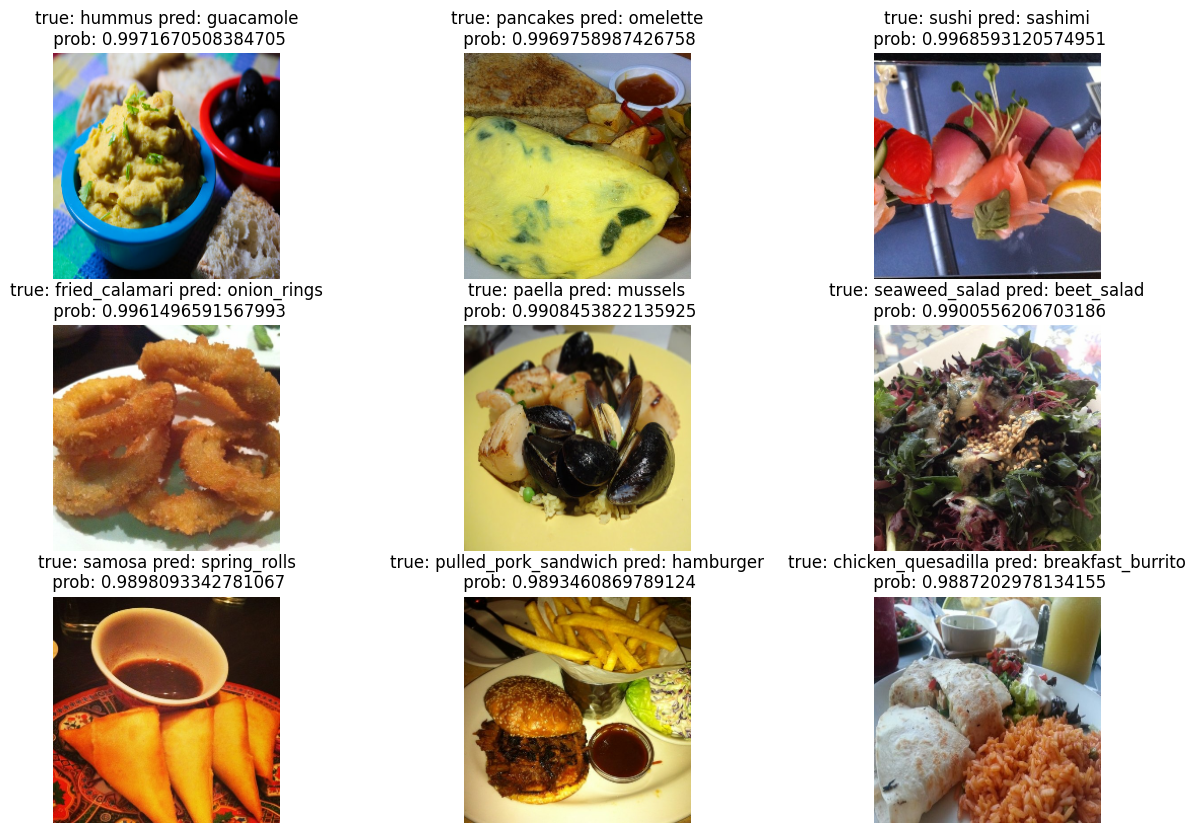

In [68]:
# visualize wrong test samples
images_to_view = 9
start_index = 0
plt.figure(figsize=(15, 10))
# .itertuples() used to iterate over dataframe rows as tuples
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=False) # since image path is stored in index 1
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # only interested in those variables
  plt.imshow(img/255.)
  plt.title(f'true: {y_true_classname} pred: {y_pred_classname}\n prob: {pred_prob}')
  plt.axis(False);

# '''
# efficientnet model maybe does not do autoscaling ?
# need to use imshow(img/255.), or set scale=True for proper image visualization
# maybe retrain with rescaling (?), gives wrong pred when scaled image given
# (gives edamame for all, maybe because most unique, and model not trained on
# rescaled data)
# '''

### **Making own predictions**

In [48]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
unzip_data('custom_food_images.zip')

--2023-10-16 10:44:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.123.207, 74.125.139.207, 173.194.210.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.123.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip.1’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.08s   

2023-10-16 10:44:00 (153 MB/s) - ‘custom_food_images.zip.1’ saved [13192985/13192985]



In [53]:
custom_food_images = ['custom_food_images/' + filepath for filepath in os.listdir('custom_food_images')]
custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/ramen.jpeg']

1/1 [==============================] - 0s 129ms/step


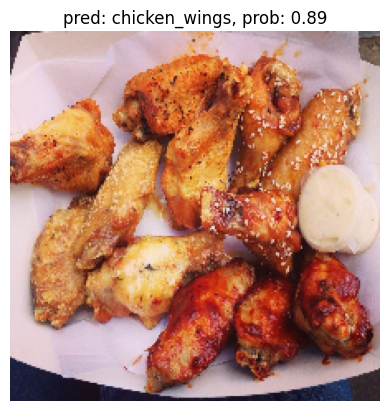

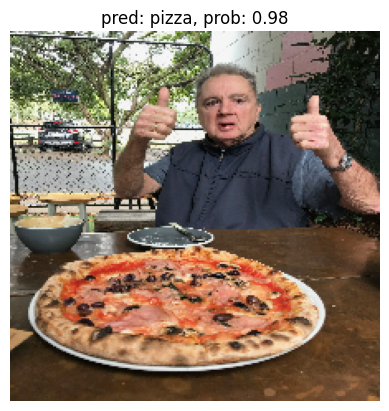

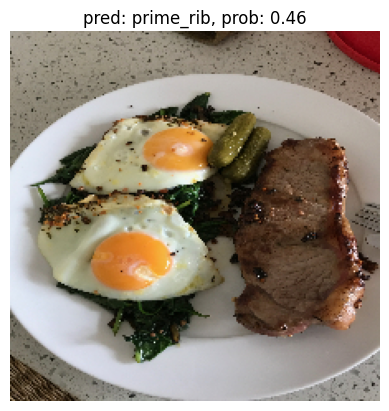

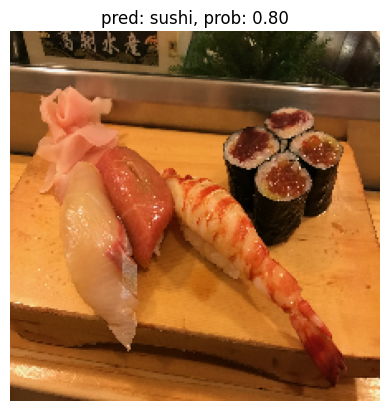

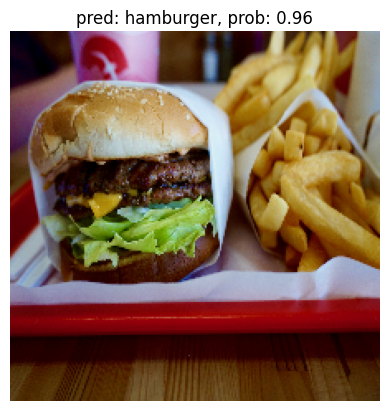

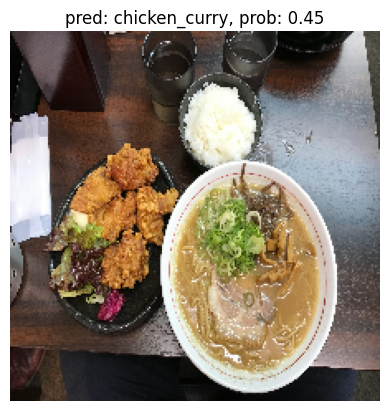

In [69]:
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False)
  pred_probs = model.predict(tf.expand_dims(img, axis=0))
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f'pred: {class_names[pred_probs.argmax()]}, prob: {pred_probs.max():.2f}')
  plt.axis(False);
